In [1]:
import lhsmdu
import dynesty
import numpy as np
import george
from george import kernels
import schwimmbad
import dynesty.plotting as dyplot
from dynesty import utils as dyfunc
import time
import matplotlib.pyplot as plt

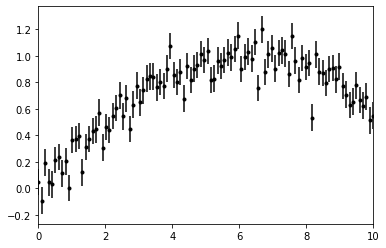

In [9]:
x=np.linspace(0,10,100)
yerr=0.1*np.ones_like(x)
np.random.seed(1234)
y=np.sin(x/4) + yerr*np.random.randn(len(x)) #*np.sin(x[1]/4)* np.sin(x[2]*2) 
plt.errorbar(x,y,yerr=yerr,fmt='.k',capsize=0)
plt.xlim(0,10)
plt.show()

In [10]:
kernel=np.var(y) * kernels.ExpSquaredKernel(1**2)
       #* kernels.ExpSquaredKernel(4**2,ndim=3,axes=1)\
       #* kernels.ExpSquaredKernel(0.5**2,ndim=3,axes=2)

gp = george.GP(kernel)
gp.compute(x, yerr)
print(gp.get_parameter_vector())
print(np.sqrt(np.exp(gp.get_parameter_vector())))
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

[-2.41667386  0.        ]
[0.29869361 1.        ]
Initial ln-likelihood: 55.23


In [11]:
from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
#print(result)

gp.set_parameter_vector(result.x)
print("Final ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

print(result.x)
print(np.sqrt(np.exp(result.x)))

Final ln-likelihood: 75.55
[-0.24044495  3.78481248]
[0.88672314 6.63531564]


In [12]:
ndim=2
def loglike(p):
    try:        
        gp.set_parameter_vector(p)
        return gp.log_likelihood(y)
    except:
        return - 1e14
def ptform(u): #[-1.4,4] [0,7] [-2.8,3]
    return [u[0]*15 -5, u[1]*7] #, u[2]*7 , u[3]*5.8-2.8]

In [13]:
sampler = dynesty.NestedSampler(loglike, ptform, ndim, nlive=1000, pool= schwimmbad.MultiPool())

iter: 3656 | +1000 | bound: 0 | nc: 1 | ncall: 35719 | eff(%): 13.035 | loglstar:   -inf < 75.552 <    inf | logz: 72.106 +/-  0.074 | dlogz:  0.001 >  1.009                                         

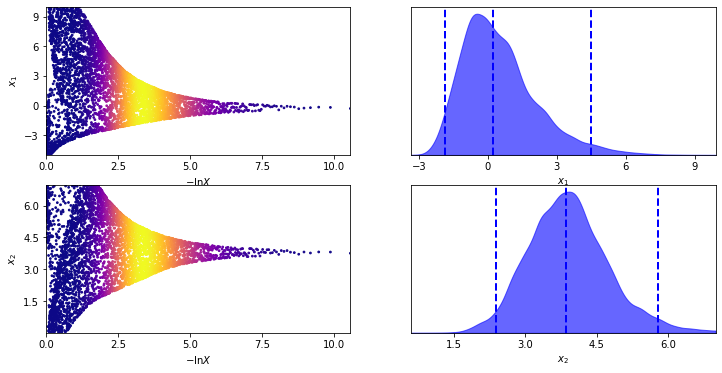

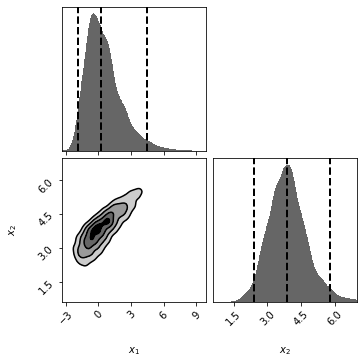

In [14]:
sampler.run_nested()
results = sampler.results
tfig, taxes = dyplot.traceplot(results)
cfig, caxes = dyplot.cornerplot(results)

In [15]:
samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
new_samples = dyfunc.resample_equal(samples, weights)
med=np.quantile(new_samples[:,1],[.5])
print(med)
print(np.sqrt(np.exp(med)))

[3.85775866]
[6.88179369]
